成功从 'Buetter_pseudotime.csv' 加载了 288 个细胞的伪时间数据。


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\yLong\miniconda3\Lib\threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\yLong\miniconda3\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\yLong\miniconda3\Lib\threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yLong\miniconda3\Lib\subprocess.py", line 1611, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "<frozen codecs>", line 325, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 4: invalid continuation byte


高斯混合模型拟合与预测完成。
预测的细胞周期阶段已保存到 'Buetter_predicted_stages.csv'。
文件内容为一列数字（如0, 1, 2），每个数字代表一个细胞周期阶段。

正在生成可视化图表...


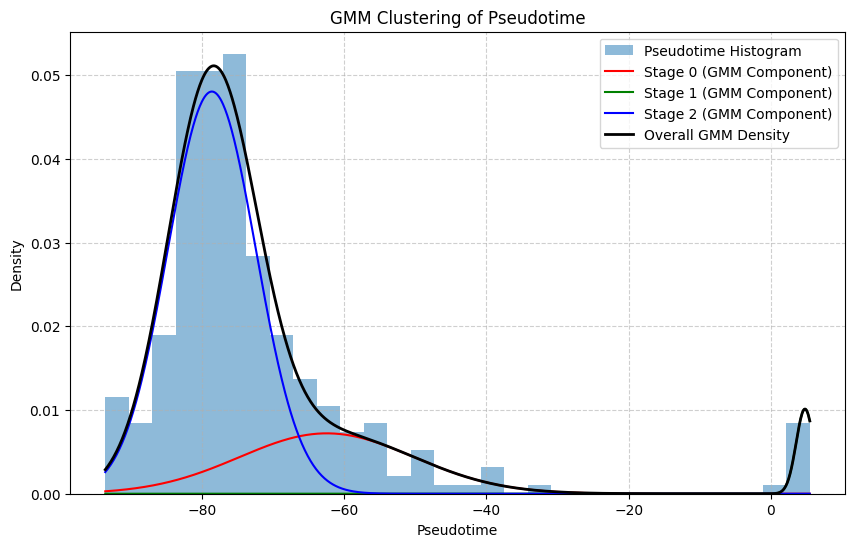

可视化图表已显示。


In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- 1. 加载数据 ---
dataset_name = 'Buetter'
input_filename = f'{dataset_name}_pseudotime.csv'
output_filename = f'{dataset_name}_predicted_stages.csv'

try:
    # 读取伪时间数据，假设文件没有表头
    pseudotime_df = pd.read_csv(input_filename, header=None)
    # 提取第一列作为我们的数据
    pseudotime_data = pseudotime_df.iloc[:, 0].values.reshape(-1, 1)
    print(f"成功从 '{input_filename}' 加载了 {len(pseudotime_data)} 个细胞的伪时间数据。")
except FileNotFoundError:
    print(f"错误：文件 '{input_filename}' 未找到。请检查文件名和路径。")
    exit()

# --- 2. 应用高斯混合模型 (GMM) ---
# 根据论文，我们使用3个组分来代表G1, S, G2/M期 
# n_components=3 指定了要寻找3个簇
# random_state=0 确保每次运行结果都一样，便于复现
gmm_model = GaussianMixture(n_components=3, random_state=0)

# 使用伪时间数据来训练模型
gmm_model.fit(pseudotime_data)

# 从训练好的模型中预测每个细胞所属的簇（即离散的细胞周期阶段）
predicted_stages = gmm_model.predict(pseudotime_data)

print("高斯混合模型拟合与预测完成。")

# --- 3. 保存结果 ---
# 将预测的阶段（标签）保存到新的CSV文件
pd.DataFrame(predicted_stages).to_csv(output_filename, header=False, index=False)
print(f"预测的细胞周期阶段已保存到 '{output_filename}'。")
print("文件内容为一列数字（如0, 1, 2），每个数字代表一个细胞周期阶段。")


# --- (可选) 4. 可视化结果以供检查 ---
print("\n正在生成可视化图表...")

plt.figure(figsize=(10, 6))

# 绘制原始伪时间数据的直方图
plt.hist(pseudotime_data, bins=30, density=True, alpha=0.5, label='Pseudotime Histogram')

# 绘制GMM拟合出的三个高斯分布曲线
x_axis = np.linspace(pseudotime_data.min(), pseudotime_data.max(), 1000).reshape(-1, 1)
colors = ['red', 'green', 'blue']
for i in range(gmm_model.n_components):
    # gmm_model.weights_ 是每个分布的权重
    # gmm_model.means_ 是每个分布的均值
    # gmm_model.covariances_ 是每个分布的方差
    pdf = gmm_model.weights_[i] * stats.norm.pdf(x_axis, gmm_model.means_[i][0], np.sqrt(gmm_model.covariances_[i][0][0]))
    plt.plot(x_axis, pdf, color=colors[i], label=f'Stage {i} (GMM Component)')

# 绘制总体的概率密度函数
logprob = gmm_model.score_samples(x_axis)
plt.plot(x_axis, np.exp(logprob), color='black', lw=2, label='Overall GMM Density')

plt.title('GMM Clustering of Pseudotime')
plt.xlabel('Pseudotime')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("可视化图表已显示。")